In [1]:
!pip install mediapipe -q
!pip install opencv-python -q
!pip install scikit-learn -q
!pip install wurlitzer -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.25.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
google-cloud-aiplatform 0.6.0a1 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-automl 1.0.1 requires google-api-core[grpc]<2.0.0dev,>=1.14.0, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires protobuf<4.0.0dev,>=3.12.0, but y

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import random
import numpy as np
import pandas as pd
import mediapipe as mp
from torch.utils.data import Dataset, DataLoader


2024-08-21 14:19:23.409460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 14:19:23.409608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 14:19:23.541702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class HandKeypointDataset(Dataset):
    def __init__(self, csv_file, data_dir, label_map, mean, std, augment=False, augment_method=None):
        self.data_frame = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.label_map = label_map
        self.augment = augment
        self.augment_method = augment_method
        self.mean = mean.numpy() if isinstance(mean, torch.Tensor) else mean
        self.std = std.numpy() if isinstance(std, torch.Tensor) else std
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        video_id = row['video_id']
        label = row['label']
        frames = np.load(os.path.normpath(os.path.join(self.data_dir, f'{video_id}.npy')))
        label_idx = self.label_map[label]

        if self.augment and self.augment_method:
            frames = self.augment_method(frames)
        
        frames = self.normalize_frames(frames)
        return torch.tensor(frames, dtype=torch.float32), torch.tensor(label_idx, dtype=torch.long)

    def normalize_frames(self, frames):
        epsilon = 1e-8
        return (frames - self.mean) / (self.std + epsilon)

    
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    n_samples = 0

    for frames, _ in loader:
        frames = frames.view(frames.size(0), -1)
        mean += frames.mean(1).sum(0)
        std += frames.std(1).sum(0)
        n_samples += frames.size(0)

    mean /= n_samples
    std /= n_samples
    return mean, std




# 标签编码
labels = pd.read_csv('/kaggle/input/gesture-data/Updated_Train.csv')['label'].unique()
label_map = {label: idx for idx, label in enumerate(labels)}

# 初步创建数据集和数据加载器
csv_file = '/kaggle/input/gesture-data/Updated_Train.csv'
data_dir = '/kaggle/input/gesture-data/processed_train_new/processed_train'

train_dataset_initial = HandKeypointDataset(csv_file, data_dir, label_map, mean=0, std=1, augment=False)
train_loader_initial = DataLoader(train_dataset_initial, batch_size=32, shuffle=True, num_workers=4)

# 计算均值和标准差
train_mean, train_std = calculate_mean_std(train_loader_initial)
print(train_mean, train_std)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor(0.1196) tensor(0.2007)


In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN

# 读取CSV文件
df = pd.read_csv(csv_file)

# 提取特征和标签
X = df['video_id'].values.reshape(-1, 1)
y = df['label'].values

# 使用上采样
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# 更新数据集
resampled_df = pd.DataFrame({'video_id': X_resampled.flatten(), 'label': y_resampled})
resampled_csv_file = 'Resampled_Train.csv'
resampled_df.to_csv(resampled_csv_file, index=False)

In [5]:
# 创建数据集和数据加载器
# train_dataset = HandKeypointDataset('/kaggle/input/gesture-data/Updated_Train.csv', '/kaggle/input/gesture-data/processed_train_new/processed_train', label_map, mean=train_mean, std=train_std, augment=False)
train_dataset = HandKeypointDataset(resampled_csv_file, data_dir, label_map, mean=train_mean, std=train_std, augment=False)
validation_dataset = HandKeypointDataset('/kaggle/input/gesture-data/Updated_Validation.csv', '/kaggle/input/gesture-data/processed_validation/processed_validation', label_map, mean=train_mean, std=train_std, augment=False)
test_dataset = HandKeypointDataset('/kaggle/input/gesture-data/Updated_Test_new.csv', '/kaggle/input/gesture-data/processed_test_new/processed_test', label_map, mean=train_mean, std=train_std, augment=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [6]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.context_vector = nn.Linear(hidden_size * 2, 1, bias=False)

    def forward(self, lstm_output):
        attn_weights = torch.tanh(self.attention(lstm_output))
        attn_weights = self.context_vector(attn_weights).squeeze(-1)
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.sum(attn_weights.unsqueeze(-1) * lstm_output, dim=1)
        return context, attn_weights

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers, dropout_rate=0.3):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.attention = Attention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context, attn_weights = self.attention(lstm_out)
        context = self.dropout(context)
        context = self.batch_norm(context)
        out = self.fc(context)
        return out

In [7]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_layers=6, num_heads=8, hidden_dim=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x):
        x = x.squeeze(1)
        x = self.embedding(x)  # (batch_size, seq_len, hidden_dim)
        x = self.pos_encoder(x.transpose(0, 1))  # (seq_len, batch_size, hidden_dim)
        x = self.transformer_encoder(x)  # (seq_len, batch_size, hidden_dim)
        x = x.mean(dim=0)  # 或者取最后一个时间步的输出：x = x[-1, :, :]
        x = self.dropout(x)  # 添加Dropout层
        x = self.fc(x)  # (batch_size, num_classes)
        return x
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class GestureRecognitionModel(nn.Module):
    def __init__(self, num_classes, feature_dim=768):
        super(GestureRecognitionModel, self).__init__()
        self.transformer = TransformerModel(input_dim=feature_dim, num_classes=num_classes)

    def forward(self, x):
        output = self.transformer(x)
        return output

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].unsqueeze(0)
        return self.dropout(x)

class TransformerHandGesture(nn.Module):
    def __init__(self, feature_dim, num_classes, num_heads=4, num_layers=2, dropout=0.1):
        super(TransformerHandGesture, self).__init__()
        self.input_fc = nn.Linear(feature_dim, 128)
        self.positional_encoding = PositionalEncoding(128)
        encoder_layers = nn.TransformerEncoderLayer(d_model=128, nhead=num_heads, dim_feedforward=256, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.input_fc(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.dropout(x[:, 0, :])  # 取第一个时间步的输出作为全局表示
        x = self.fc(x)
        return x

In [9]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_loss = None

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'早停计数: {self.counter} / {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        """当验证损失减少时保存模型。"""
        if self.verbose:
            print(f'验证损失减少 ({self.best_loss:.6f} --> {val_loss:.6f})。保存模型...')
        torch.save(model.state_dict(), path)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Using device: cuda
CUDA Available: True
Number of GPUs: 1
Current GPU: 0
GPU Name: Tesla P100-PCIE-16GB


In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(f'Using device: {device}')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='inference_feedback_manager')

# 或者将特定模块的日志级别设为 ERROR
import logging
logging.getLogger('inference_feedback_manager').setLevel(logging.ERROR)


# 检查数据样本
for inputs, labels in train_loader:
    print("Input shape:", inputs.shape)
    print("Label shape:", labels.shape)
    break



Using device: cuda


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Input shape: torch.Size([32, 37, 63])
Label shape: torch.Size([32])


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [12]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs, early_stopping, model_path='best_model.pth', checkpoint_interval=5, log_each_epoch=True, show_progress=True):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        if show_progress:
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} ', leave=False)
        else:
            progress_bar = train_loader

        for inputs, labels in progress_bar:
            inputs = inputs.float().to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if show_progress:
                progress_bar.set_postfix(loss=f'{loss.item():.4f}', accuracy=f'{(correct / total) * 100:.2f}%')

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        if log_each_epoch:
            print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.float().to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(validation_loader.dataset)
        val_losses.append(epoch_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        if log_each_epoch:
            print(f'Epoch {epoch + 1}/{num_epochs}  - Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            torch.save(model.state_dict(), model_path)
            print(f'Saved best model with loss: {best_val_loss:.4f}')

        scheduler.step()

        early_stopping(epoch_loss, model, model_path)

        if early_stopping.early_stop:
            print("Early Stopping")
            break

    model.load_state_dict(torch.load(model_path))
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [13]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # plt.tight_layout()
    plt.show()



In [14]:
print(label_map)

{'No gesture': 0, 'Pushing Two Fingers Away': 1, 'Sliding Two Fingers Down': 2, 'Pushing Hand Away': 3, 'Shaking Hand': 4, 'Pulling Two Fingers In': 5, 'Stop Sign': 6, 'Zooming In With Two Fingers': 7, 'Sliding Two Fingers Up': 8, 'Zooming Out With Two Fingers': 9, 'Zooming In With Full Hand': 10, 'Swiping Right': 11, 'Thumb Down': 12, 'Pulling Hand In': 13, 'Zooming Out With Full Hand': 14, 'Swiping Left': 15, 'Swiping Up': 16, 'Sliding Two Fingers Left': 17, 'Swiping Down': 18, 'Thumb Up': 19, 'Sliding Two Fingers Right': 20}


In [15]:
input_dim = 63
num_heads = 8
num_layers = 4
num_classes = len(label_map)
hidden_dim = 256  # 确保hidden_dim是偶数
num_epochs = 25

def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.LSTM):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
            
model2 = GestureRecognitionModel(num_classes=num_classes, feature_dim=63).to(device)
# model2 = TransformerHandGesture(feature_dim=63, num_classes=21).to(device)
model2.apply(weights_init)
optimizer = optim.AdamW(model2.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=100, min_delta=0.01)

model_transformer, train_losses_transformer, val_losses_transformer, train_accuracies_transformer, val_accuracies_transformer = train_model(
    model2, train_loader, validation_loader, criterion, optimizer, num_epochs=25, early_stopping=early_stopping, log_each_epoch=True, show_progress=True
)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1/25 :   0%|          | 0/2871 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/25 : 100%|█████████▉| 2869/2871 [01:51<00:00, 25.84it/s, accuracy=52.65%, loss=1.0060]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = o

Epoch 1/25 - Train Loss: 1.3461, Train Accuracy: 0.5265


Epoch 1/25  - Validation Loss: 1.1081, Validation Accuracy: 0.6297
Saved best model with loss: 1.1081


Epoch 2/25 - Train Loss: 0.9939, Train Accuracy: 0.6424


Epoch 2/25  - Validation Loss: 1.0243, Validation Accuracy: 0.6700
Saved best model with loss: 1.0243


Epoch 3/25 - Train Loss: 0.9080, Train Accuracy: 0.6801


Epoch 3/25  - Validation Loss: 0.9959, Validation Accuracy: 0.6836
Saved best model with loss: 0.9959


Epoch 4/25 - Train Loss: 0.8523, Train Accuracy: 0.7015


Epoch 4/25  - Validation Loss: 0.9142, Validation Accuracy: 0.6919
Saved best model with loss: 0.9142


Epoch 5/25 - Train Loss: 0.8107, Train Accuracy: 0.7184


Epoch 5/25  - Validation Loss: 0.9150, Validation Accuracy: 0.6880


Epoch 6/25 - Train Loss: 0.7835, Train Accuracy: 0.7271


Epoch 6/25  - Validation Loss: 0.9366, Validation Accuracy: 0.7060


Epoch 7/25 - Train Loss: 0.7594, Train Accuracy: 0.7380


Epoch 7/25  - Validation Loss: 0.9299, Validation Accuracy: 0.6859


Epoch 8/25 - Train Loss: 0.7424, Train Accuracy: 0.7436


Epoch 8/25  - Validation Loss: 0.9059, Validation Accuracy: 0.7035
Saved best model with loss: 0.9059


Epoch 9/25 - Train Loss: 0.7231, Train Accuracy: 0.7498


Epoch 9/25  - Validation Loss: 0.8610, Validation Accuracy: 0.7245
Saved best model with loss: 0.8610


Epoch 10/25 - Train Loss: 0.7059, Train Accuracy: 0.7571


Epoch 10/25  - Validation Loss: 0.8770, Validation Accuracy: 0.7309


Epoch 11/25 - Train Loss: 0.5976, Train Accuracy: 0.7964


Epoch 11/25  - Validation Loss: 0.8111, Validation Accuracy: 0.7478
Saved best model with loss: 0.8111


Epoch 12/25 - Train Loss: 0.5656, Train Accuracy: 0.8087


Epoch 12/25  - Validation Loss: 0.8291, Validation Accuracy: 0.7455


Epoch 13/25 - Train Loss: 0.5494, Train Accuracy: 0.8147


Epoch 13/25  - Validation Loss: 0.8465, Validation Accuracy: 0.7505


Epoch 14/25 - Train Loss: 0.5340, Train Accuracy: 0.8213


Epoch 14/25  - Validation Loss: 0.8653, Validation Accuracy: 0.7468


Epoch 15/25 - Train Loss: 0.5227, Train Accuracy: 0.8254


Epoch 15/25  - Validation Loss: 0.8702, Validation Accuracy: 0.7503


Epoch 16/25 - Train Loss: 0.5102, Train Accuracy: 0.8294


Epoch 16/25  - Validation Loss: 0.8954, Validation Accuracy: 0.7418


Epoch 17/25 - Train Loss: 0.4988, Train Accuracy: 0.8341


Epoch 17/25  - Validation Loss: 0.8940, Validation Accuracy: 0.7462


Epoch 18/25 - Train Loss: 0.4881, Train Accuracy: 0.8389


Epoch 18/25  - Validation Loss: 0.9159, Validation Accuracy: 0.7471


Epoch 19/25 - Train Loss: 0.4772, Train Accuracy: 0.8429


Epoch 19/25  - Validation Loss: 0.9280, Validation Accuracy: 0.7447


Epoch 20/25 - Train Loss: 0.4673, Train Accuracy: 0.8472


Epoch 20/25  - Validation Loss: 0.9589, Validation Accuracy: 0.7378


Epoch 21/25 - Train Loss: 0.4484, Train Accuracy: 0.8547


Epoch 21/25  - Validation Loss: 0.9588, Validation Accuracy: 0.7431


Epoch 22/25 - Train Loss: 0.4442, Train Accuracy: 0.8564


Epoch 22/25  - Validation Loss: 0.9650, Validation Accuracy: 0.7427


Epoch 23/25 - Train Loss: 0.4411, Train Accuracy: 0.8573


Epoch 23/25  - Validation Loss: 0.9711, Validation Accuracy: 0.7420


Epoch 24/25 - Train Loss: 0.4410, Train Accuracy: 0.8574


Epoch 24/25  - Validation Loss: 0.9759, Validation Accuracy: 0.7427


Epoch 25/25 - Train Loss: 0.4374, Train Accuracy: 0.8592


Epoch 25/25  - Validation Loss: 0.9788, Validation Accuracy: 0.7436


In [ ]:
# 模型参数
# 初始化模型
input_size = 63  # 输入特征维度
hidden_size = 256  # 隐藏层神经元数量
output_size = 21  # 输出类别数量，根据实际情况调整
num_layers = 2  # LSTM层数量
dropout = 0.3  # Dropout率
lr = 0.001
weight_decay = 0.0001

def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.LSTM):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

# 初始化模型、损失函数和优化器
model = LSTMAttentionModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=output_size, dropout_rate=dropout).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

early_stopping = EarlyStopping(patience=100, min_delta=0.01)


model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, validation_loader, criterion, optimizer, num_epochs=25, early_stopping=early_stopping, log_each_epoch=True, show_progress=True
    )


Epoch 1/25 - Train Loss: 0.9433, Train Accuracy: 0.7131


Epoch 1/25  - Validation Loss: 0.8560, Validation Accuracy: 0.7369
Saved best model with loss: 0.8560


Epoch 2/25 - Train Loss: 0.7260, Train Accuracy: 0.7800
Epoch 2/25  - Validation Loss: 0.8068, Validation Accuracy: 0.7671
Saved best model with loss: 0.8068


Epoch 3/25 - Train Loss: 0.6784, Train Accuracy: 0.7934


Epoch 3/25  - Validation Loss: 0.8176, Validation Accuracy: 0.7621


Epoch 4/25 - Train Loss: 0.6484, Train Accuracy: 0.8023


Epoch 4/25  - Validation Loss: 0.7451, Validation Accuracy: 0.7690
Saved best model with loss: 0.7451


Epoch 5/25 - Train Loss: 0.6263, Train Accuracy: 0.8092


Epoch 5/25  - Validation Loss: 0.7423, Validation Accuracy: 0.7851
Saved best model with loss: 0.7423


Epoch 6/25 - Train Loss: 0.6085, Train Accuracy: 0.8150


Epoch 6/25  - Validation Loss: 0.7470, Validation Accuracy: 0.7810


Epoch 7/25 - Train Loss: 0.5966, Train Accuracy: 0.8179
Epoch 7/25  - Validation Loss: 0.7598, Validation Accuracy: 0.7798


Epoch 8/25 - Train Loss: 0.5867, Train Accuracy: 0.8206


Epoch 8/25  - Validation Loss: 0.7286, Validation Accuracy: 0.7911
Saved best model with loss: 0.7286


Epoch 9/25 - Train Loss: 0.5777, Train Accuracy: 0.8240


Epoch 9/25  - Validation Loss: 0.7179, Validation Accuracy: 0.7745
Saved best model with loss: 0.7179


Epoch 10/25 - Train Loss: 0.5714, Train Accuracy: 0.8258


Epoch 10/25  - Validation Loss: 0.7155, Validation Accuracy: 0.7911
Saved best model with loss: 0.7155


Epoch 11/25 - Train Loss: 0.4888, Train Accuracy: 0.8521


Epoch 11/25  - Validation Loss: 0.6694, Validation Accuracy: 0.8065
Saved best model with loss: 0.6694


Epoch 12/25 - Train Loss: 0.4626, Train Accuracy: 0.8597


Epoch 12/25  - Validation Loss: 0.6711, Validation Accuracy: 0.8065


Epoch 13/25 - Train Loss: 0.4507, Train Accuracy: 0.8641


Epoch 13/25  - Validation Loss: 0.6678, Validation Accuracy: 0.8061
Saved best model with loss: 0.6678


Epoch 14/25 - Train Loss: 0.4399, Train Accuracy: 0.8673


Epoch 14/25  - Validation Loss: 0.6792, Validation Accuracy: 0.8061


Epoch 15/25 - Train Loss: 0.4327, Train Accuracy: 0.8693


Epoch 15/25  - Validation Loss: 0.6896, Validation Accuracy: 0.8047


Epoch 16/25 - Train Loss: 0.4266, Train Accuracy: 0.8715


Epoch 16/25  - Validation Loss: 0.6825, Validation Accuracy: 0.8082


Epoch 17/25 - Train Loss: 0.4183, Train Accuracy: 0.8739


Epoch 17/25  - Validation Loss: 0.7001, Validation Accuracy: 0.8042


Epoch 18/25 - Train Loss: 0.4131, Train Accuracy: 0.8751


Epoch 18/25  - Validation Loss: 0.7065, Validation Accuracy: 0.8051


Epoch 19/25 - Train Loss: 0.4065, Train Accuracy: 0.8774


Epoch 19/25  - Validation Loss: 0.7087, Validation Accuracy: 0.8045


Epoch 20/25 - Train Loss: 0.4010, Train Accuracy: 0.8786


Epoch 20/25  - Validation Loss: 0.7149, Validation Accuracy: 0.8052


Epoch 21/25 - Train Loss: 0.3858, Train Accuracy: 0.8846


Epoch 21/25  - Validation Loss: 0.7142, Validation Accuracy: 0.8052


Epoch 22/25 - Train Loss: 0.3831, Train Accuracy: 0.8859


Epoch 22/25  - Validation Loss: 0.7167, Validation Accuracy: 0.8035


Epoch 23/25 - Train Loss: 0.3807, Train Accuracy: 0.8863


Epoch 23/25  - Validation Loss: 0.7162, Validation Accuracy: 0.8058


Epoch 24/25 - Train Loss: 0.3788, Train Accuracy: 0.8870


Epoch 24/25  - Validation Loss: 0.7206, Validation Accuracy: 0.8054


Epoch 25/25 :  19%|█▊        | 532/2871 [00:08<00:35, 65.95it/s, accuracy=88.96%, loss=0.2805]

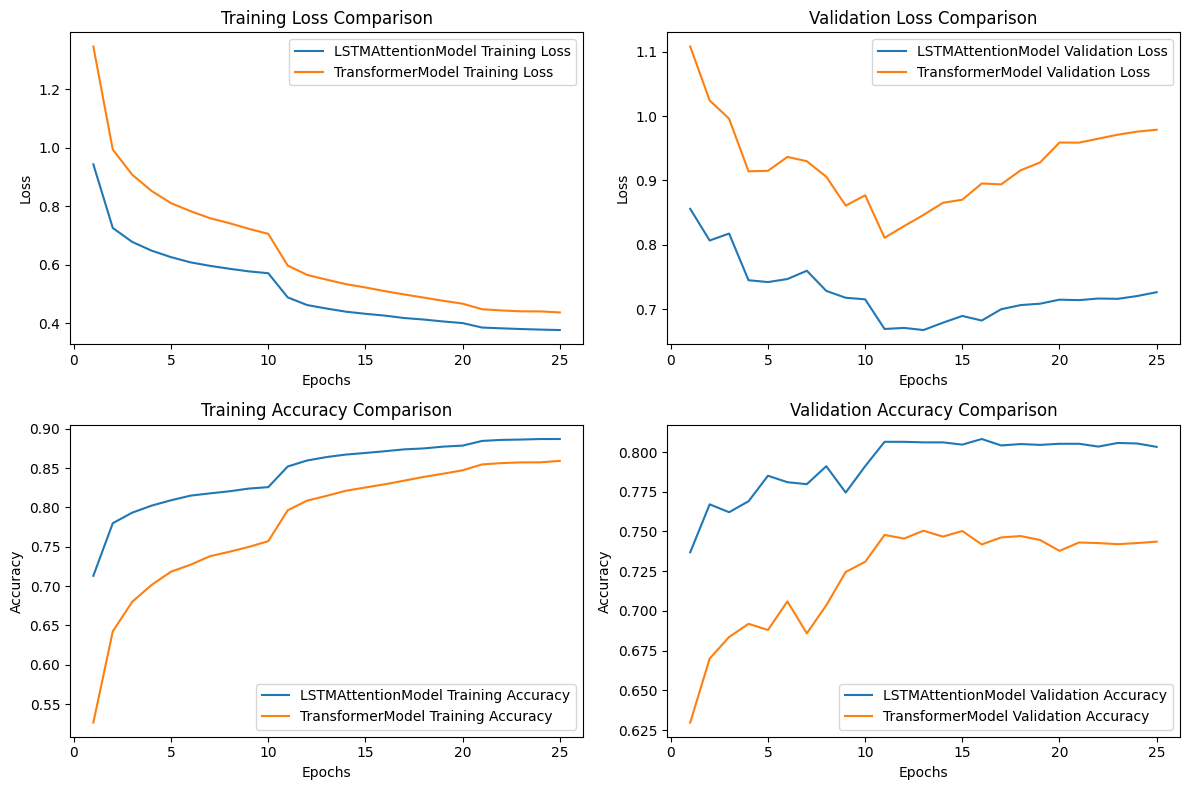

In [21]:
def plot_comparison_metrics(metrics1, metrics2, label1="Model 1", label2="Model 2"):
    epochs = range(1, len(metrics1['train_losses']) + 1)

    plt.figure(figsize=(12, 8))
    
    # Plot Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics1['train_losses'], label=f'{label1} Training Loss')
    plt.plot(epochs, metrics2['train_losses'], label=f'{label2} Training Loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics1['val_losses'], label=f'{label1} Validation Loss')
    plt.plot(epochs, metrics2['val_losses'], label=f'{label2} Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics1['train_accuracies'], label=f'{label1} Training Accuracy')
    plt.plot(epochs, metrics2['train_accuracies'], label=f'{label2} Training Accuracy')
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics1['val_accuracies'], label=f'{label1} Validation Accuracy')
    plt.plot(epochs, metrics2['val_accuracies'], label=f'{label2} Validation Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming that the training process for both models has been completed
# and the results (losses and accuracies) for the second model are stored similarly
metrics_model1 = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}

# After training model2, similar to how model1 was trained
# Assuming model2_results contains the train_losses, val_losses, train_accuracies, val_accuracies for model2
metrics_model2 = {
    'train_losses': train_losses_transformer,  # Replace with actual results
    'val_losses': val_losses_transformer,      # Replace with actual results
    'train_accuracies': train_accuracies_transformer,  # Replace with actual results
    'val_accuracies': val_accuracies_transformer       # Replace with actual results
}

# Plotting comparison
plot_comparison_metrics(metrics_model1, metrics_model2, label1="LSTMAttentionModel", label2="TransformerModel")

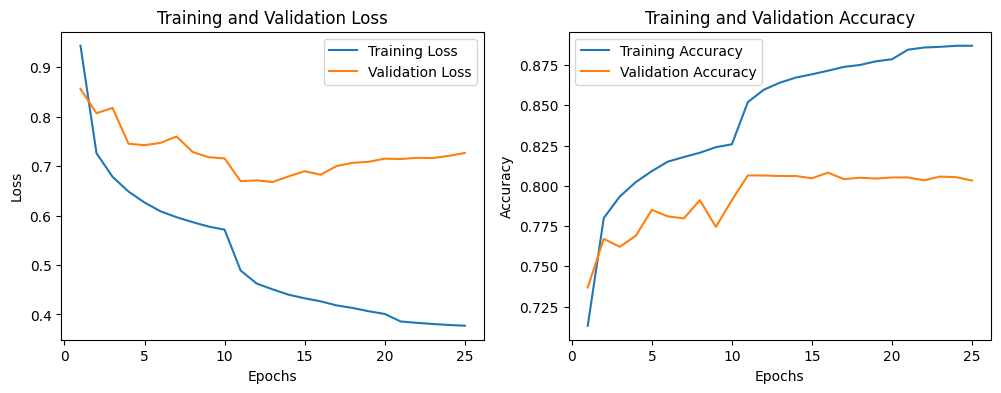

In [22]:
# 绘制训练和验证损失及准确率曲线
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


def evaluate_model(model, data_loader, label_map, show_confusion_matrix=True):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    if show_confusion_matrix:
        # 绘制混淆矩阵
        cm = confusion_matrix(all_labels, all_predictions, labels=list(label_map.values()))
        fig, ax = plt.subplots(figsize=(15, 15))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
        disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
        plt.show()

    return accuracy, precision, recall, f1

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.8099
Precision: 0.8475
Recall: 0.8099
F1 Score: 0.8194


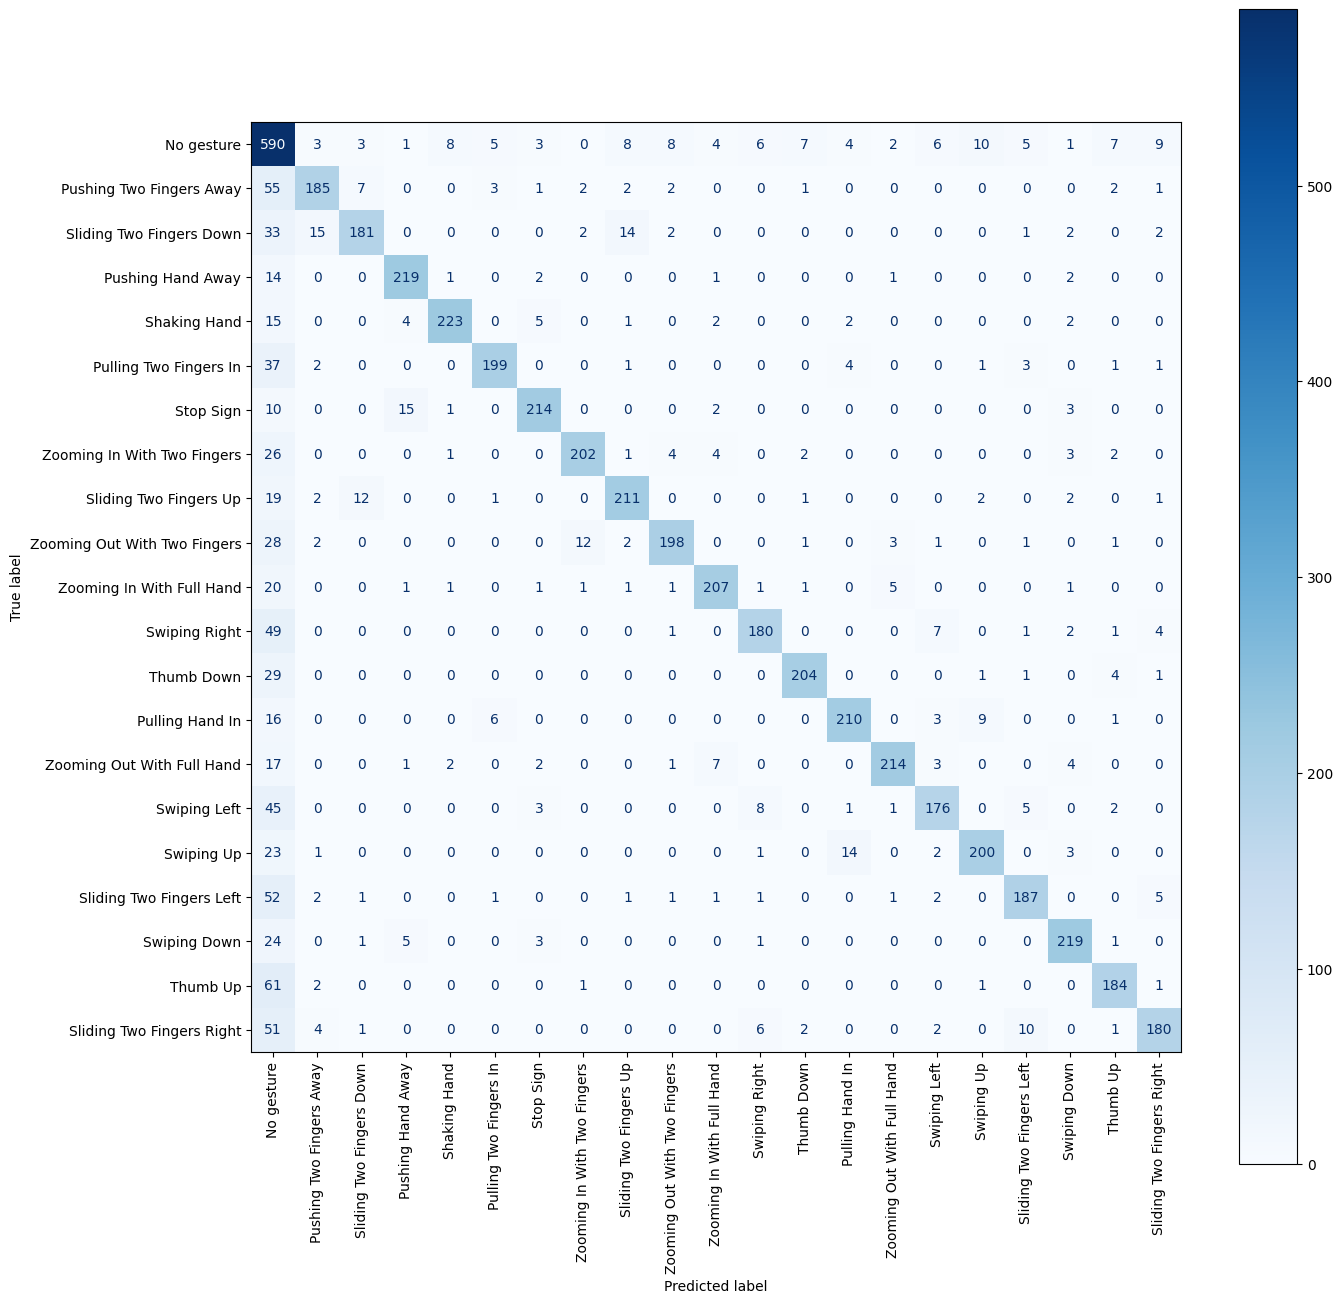

In [24]:
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader, label_map, show_confusion_matrix=True)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.7487
Precision: 0.7783
Recall: 0.7487
F1 Score: 0.7539


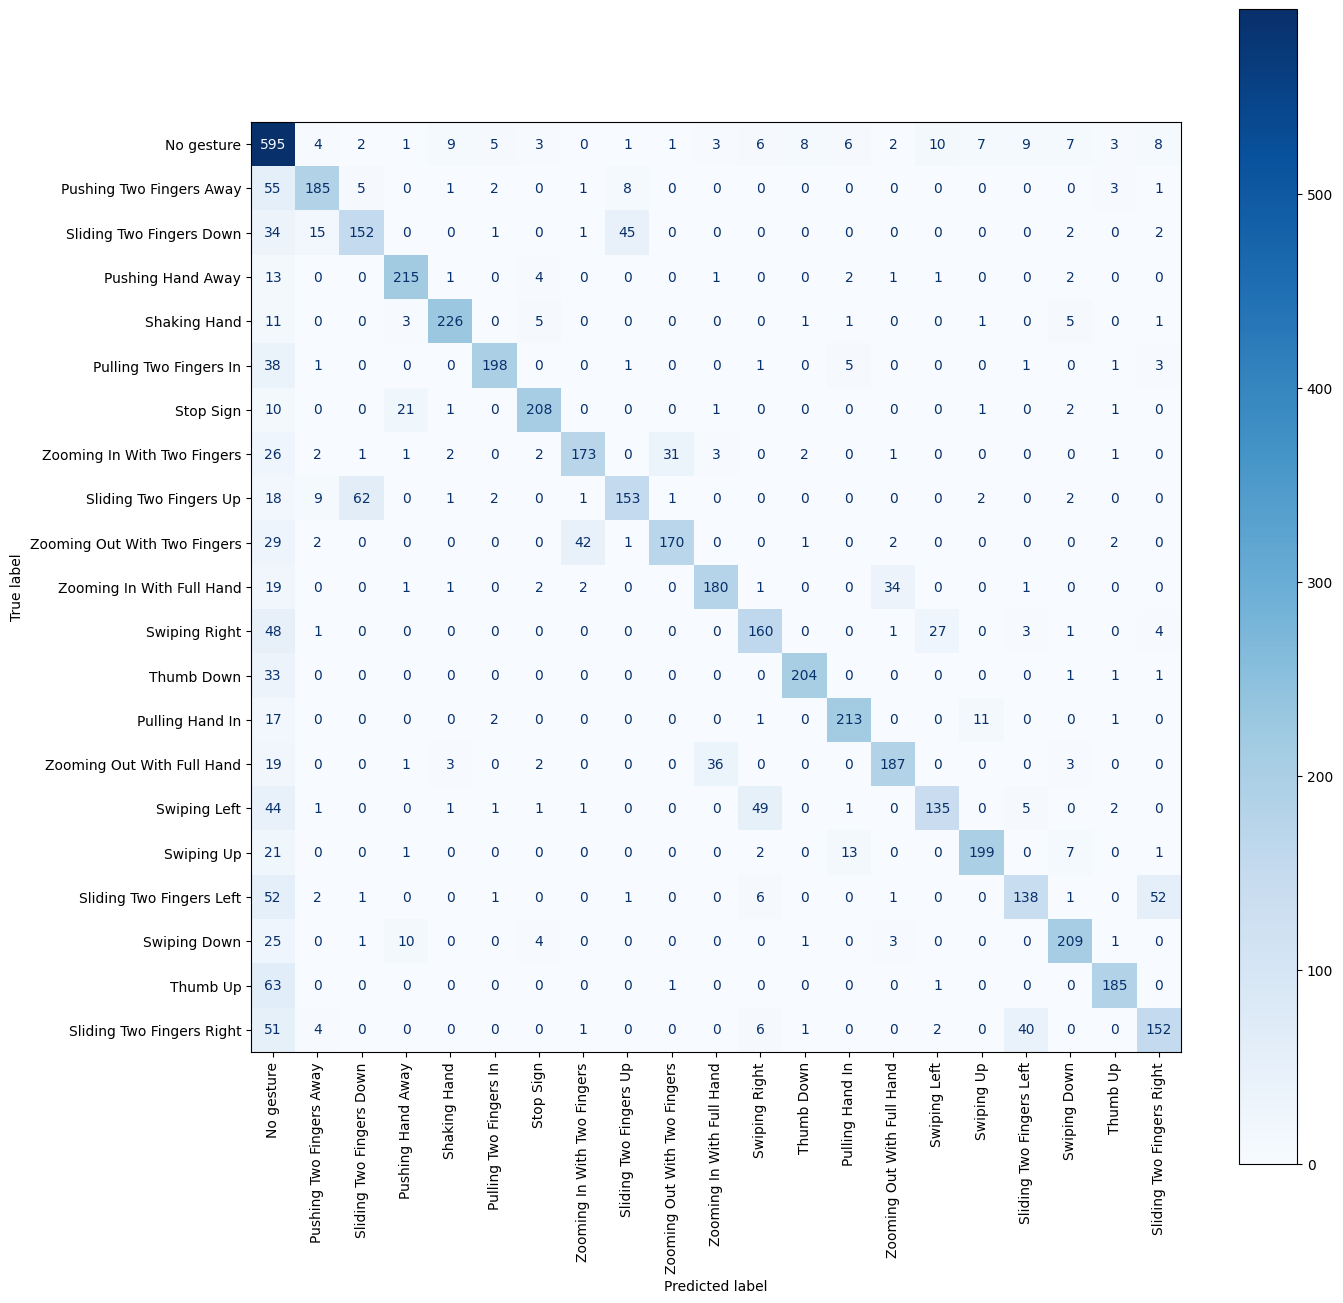

In [25]:
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model2, test_loader, label_map, show_confusion_matrix=True)